In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from qadence import *
from qadence.types import BasisSet, ReuploadScaling

In [31]:
def dfdx_equation(x: torch.Tensor, f: torch.Tensor) -> torch.Tensor:
    """Derivative as per the equation."""
    return 4*x**3 + x**2 - 2*x - 0.5

In [30]:
def f_exact(x: torch.Tensor) -> torch.Tensor:
    return x**4 + x**3 / 3 - x**2 - x/2 + 1


In [7]:
def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    """Compute a derivative of model that learns f(x), computes df/dx using torch.autograd."""
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs = torch.ones_like(inputs),
        create_graph = True,
        retain_graph = True,
    )[0]
    return grad

In [37]:
# Mean-squared error as the comparison criterion
criterion = torch.nn.MSELoss()
def loss_fn(model: torch.nn.Module, inputs: torch.Tensor, x_reg: torch.Tensor, reg_weight: float) -> torch.Tensor:
    
    # Equation loss
    model_output = model(inputs) 
    deriv_model = calc_deriv(model_output, inputs)
    deriv_exact = dfdx_equation(inputs,model_output)
    ode_loss = criterion(deriv_model, deriv_exact)

    # Boundary loss, f(0) = 0
    boundary_model = model(torch.tensor([[0.0]]))
    boundary_exact = torch.tensor([[1.0]])
    boundary_loss = criterion(boundary_model, boundary_exact)
    
    reg_model_output = model(x_reg)
    reg_loss = criterion(reg_model_output, f_exact(x_reg))

    return ode_loss + boundary_loss + reg_weight * reg_loss

In [9]:
def regularization_weight(nj, niter, ndrop, delta_j):
    return 1 - np.tanh((nj - ndrop) / (delta_j * niter))

In [34]:
def model_(n_qubits,depth,layers):
    

    # Feature map
    fm1 = feature_map(
        n_qubits = n_qubits,
        param = "x",
        fm_type = BasisSet.CHEBYSHEV,
        reupload_scaling = ReuploadScaling.TOWER,
    )
    fm = chain()
    for i in range(layers):
        fm = chain(fm,fm1)

    # Ansatz
    ansatz = hea(n_qubits = n_qubits, depth = depth)

    # Observable
    observable = ising_hamiltonian(n_qubits=n_qubits)#add(Z(i) for i in range(n_qubits))

    circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
    Model = QNN(circuit = circuit, observable = observable, inputs = ["x"])
    
    return Model

In [33]:
def main(n_qubits,n_epochs,n_points,depth,layers,learning_rate):
    xmin = 0.0
    xmax = 0.9
    min_loss = float('inf')

    model = model_(n_qubits,depth,layers)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    max_grad_norm = 1.0  # Gradient clipping value

    x_reg = torch.linspace(xmin, xmax, steps=20).unsqueeze(1)

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Training data. We unsqueeze essentially making each batch have a single x value.
        x_train = (xmin + (xmax-xmin)*torch.rand(n_points, requires_grad = True)).unsqueeze(1)
    
        reg_weight = regularization_weight(epoch, n_epochs, ndrop=100, delta_j=0.1)
    
        loss = loss_fn(model, x_train, x_reg, reg_weight)
    
        loss.backward()
    
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
    
        optimizer.step()
    
        if loss.item() < min_loss:
            min_loss = loss.item()
            best_model_state = model.state_dict()
    
        if loss.item() <= 0.001:
            break

    # After training, load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model,min_loss

In [35]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

space = {
    'depth': hp.quniform('depth', 3, 15, 3),
    'layers': hp.quniform('layers', 1, 5, 1),
    'learning_rate': hp.loguniform('learning_rate',  np.log(0.0001), np.log(0.1))
}

n_epochs = 250
n_points = 20
n_qubits = 6

# Define the objective function
def objective(params):
    # Convert hyperparameters to integer where necessary
    params['depth'] = int(params['depth'])
    params['layers'] = int(params['layers'])
    params['learning_rate'] = float(params['learning_rate'])

    # Call the main function with the current hyperparameters
    model, loss = main(n_qubits, n_epochs, n_points, 
                       params['depth'], params['layers'], params['learning_rate'])
    
    # Return the loss
    return {'loss': loss, 'status': STATUS_OK}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# Print the best hyperparameters
print("Best hyperparameters:", best)

100%|██| 100/100 [1:45:47<00:00, 63.48s/trial, best loss: 0.0009406460908838697]
Best hyperparameters: {'depth': 12.0, 'layers': 1.0, 'learning_rate': 0.0010903418744105688}


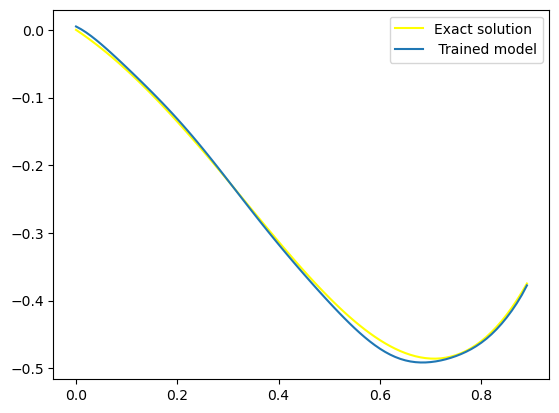

In [38]:
xmin = 0
xmax = 0.9
x_test = torch.arange(xmin, xmax, step = 0.01).unsqueeze(1)
result_exact = f_exact(x_test).flatten()

best_model,_ = main(n_qubits, n_epochs, n_points, depth=int(best['depth']), layers=int(best['layers']), learning_rate=best['learning_rate'])

result_model = best_model(x_test).flatten().detach()

plt.plot(x_test, result_exact, label = "Exact solution",color='yellow')
plt.plot(x_test, result_model, label = " Trained model")
plt.legend()

In [12]:
import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def optimization(n_qubits,n_epochs,n_points,learning_rates, depths, layers):
    min_loss = float('inf')
    for lr,d,l in itertools.product(learning_rates, depths, layers):
        model,loss = main(n_qubits,n_epochs,n_points,depth = d,layers = l,learning_rate = lr)
        results.append((lr, d, l, loss))
    
        if loss < min_loss:
            min_loss = loss
            best_params = [lr,d,l]
            best_model = model
    return best_params,results
    
n_epochs = 250
n_points = 20
n_qubits = 6
learning_rates = [0.00001, 0.0001, 0.001, 0.01]
layers = [1, 2, 3]
depths = [3, 6, 9, 12, 15]


best_model = None

# Container for results
results = []
best_params = []
# Test a single combination
model, loss = main(n_qubits, n_epochs, n_points, depth=3, layers=1, learning_rate=0.001)
print("Single combination loss:", loss)
# Generate all combinations of hyperparameters

best_params,results = optimization(n_qubits,n_epochs,n_points,learning_rates, depths, layers)

# Convert results to numpy array for easier handling
results = np.array(results)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    results[:, 0], results[:, 1], results[:, 2],
    c=results[:, 3], cmap='viridis'
)

# Label axes
ax.set_xlabel('Learning Rate')
ax.set_ylabel('depths')
ax.set_zlabel('layers')

# Add color bar which maps values to colors
cbar = plt.colorbar(sc)
cbar.set_label('Loss')

plt.show()

print("Loss in best model is: ",min_loss)


Best model loss at layer =  1  depth =  3  and learning_rate =  0.001  min_loss =  0.6617606606350142
Single combination loss: 0.6617606606350142
Best model loss at layer =  1  depth =  3  and learning_rate =  1e-05  min_loss =  59.91917449770874
Best model loss at layer =  2  depth =  3  and learning_rate =  1e-05  min_loss =  90.84840163144236
Best model loss at layer =  3  depth =  3  and learning_rate =  1e-05  min_loss =  168.91962521084736
Best model loss at layer =  1  depth =  6  and learning_rate =  1e-05  min_loss =  83.59953831699464
Best model loss at layer =  2  depth =  6  and learning_rate =  1e-05  min_loss =  66.52138317531337
Best model loss at layer =  3  depth =  6  and learning_rate =  1e-05  min_loss =  115.86631028256988
Best model loss at layer =  1  depth =  9  and learning_rate =  1e-05  min_loss =  23.215722225720523
Best model loss at layer =  2  depth =  9  and learning_rate =  1e-05  min_loss =  89.7071749716526
Best model loss at layer =  3  depth =  9  a

NameError: name 'plt' is not defined

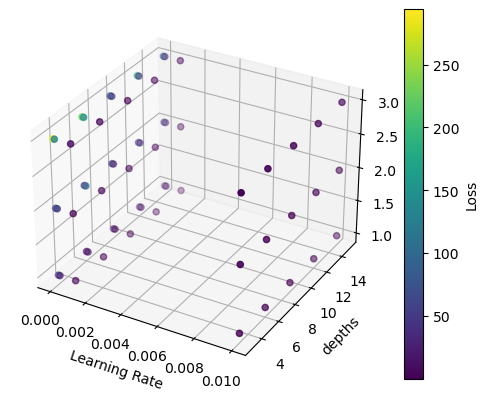

In [95]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    results[:, 0], results[:, 1], results[:, 2],
    c=results[:, 3], cmap='viridis'
)

# Label axes
ax.set_xlabel('Learning Rate')
ax.set_ylabel('depths')
ax.set_zlabel('layers')


# Add color bar which maps values to colors
cbar = plt.colorbar(sc)
cbar.set_label('Loss')

plt.show()

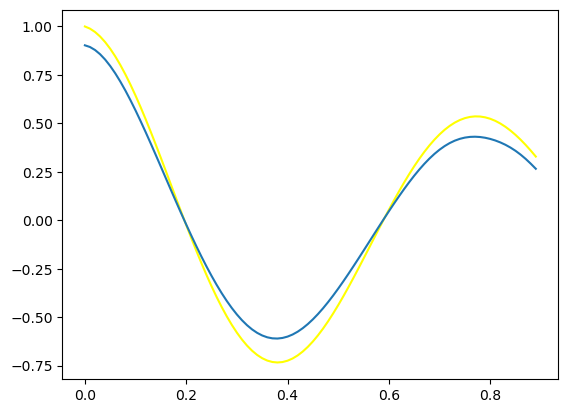

In [92]:

x_test = torch.arange(xmin, xmax, step = 0.01).unsqueeze(1)

result_exact = f_exact(x_test).flatten()

result_model = best_model(x_test).flatten().detach()

plt.plot(x_test, result_exact, label = "Exact solution",color='yellow')
plt.plot(x_test, result_model, label = " Trained model")

2.16.1


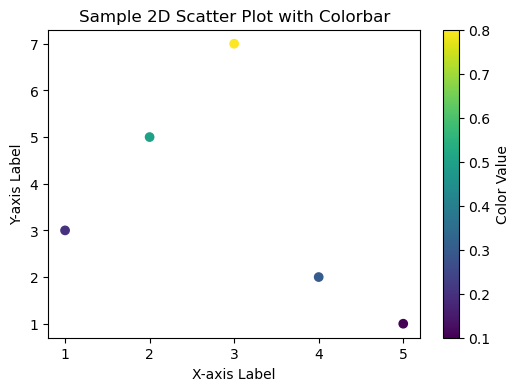

Loss at 0 iteration is: 517.1059990809416
Loss at 1 iteration is: 313.33735112281386
Loss at 2 iteration is: 396.75134270572875
Loss at 3 iteration is: 324.06949018604786
Loss at 4 iteration is: 175.7628595257951
Loss at 5 iteration is: 173.7632974773288
Loss at 6 iteration is: 90.15457120217414
Loss at 7 iteration is: 119.47475644118013
Loss at 8 iteration is: 128.2122586668294
Loss at 9 iteration is: 114.9194107075022
Loss at 10 iteration is: 92.72315066817463
Loss at 11 iteration is: 64.64611741886837
Loss at 12 iteration is: 50.63332375858833
Loss at 13 iteration is: 46.630183884211235
Loss at 14 iteration is: 45.43959467817585
Loss at 15 iteration is: 40.88807665253406
Loss at 16 iteration is: 21.608803425292557
Loss at 17 iteration is: 31.003335879549734
Loss at 18 iteration is: 33.44644592917903
Loss at 19 iteration is: 23.40410863331311
Loss at 20 iteration is: 21.934446394491946
Loss at 21 iteration is: 25.460528119089208
Loss at 22 iteration is: 22.71516807437618
Loss at 23 i

Loss at 185 iteration is: 0.12391746778688394
Loss at 186 iteration is: 0.1728500860240916
Loss at 187 iteration is: 0.18514649251934787
Loss at 188 iteration is: 0.15104095796215516
Loss at 189 iteration is: 0.07007089682802208
Loss at 190 iteration is: 0.09676172439036132
Loss at 191 iteration is: 0.09226193474450822
Loss at 192 iteration is: 0.1629689788614757
Loss at 193 iteration is: 0.06721701081103072
Loss at 194 iteration is: 0.1798452479412855
Loss at 195 iteration is: 0.08850502862438815
Loss at 196 iteration is: 0.056791274766018265
Loss at 197 iteration is: 0.1752168976231405
Loss at 198 iteration is: 0.057408955623316354
Loss at 199 iteration is: 0.09634167696179534
Loss at 200 iteration is: 0.15108496742161048
Loss at 201 iteration is: 0.20097148855286215
Loss at 202 iteration is: 0.1999394826763651
Loss at 203 iteration is: 0.1468008292991069
Loss at 204 iteration is: 0.041331317579119856
Loss at 205 iteration is: 0.07109283995705354
Loss at 206 iteration is: 0.084772525

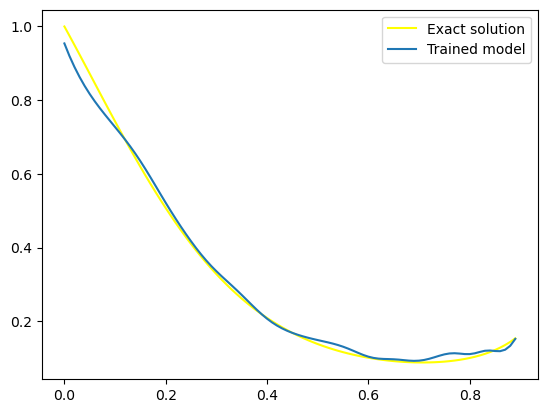

In [6]:
import torch

def dfdx_equation(x: torch.Tensor, f: torch.Tensor) -> torch.Tensor:
    """Derivative as per the equation."""
    return (5*(4*x**3 + x**2 - 2*x - 0.5))*f#-8*(0.1 + torch.tan(8*x))*f

def f_exact(x: torch.Tensor) -> torch.Tensor:
    return torch.exp(5*(x**4 + (1/3)*x**3 - x**2 - 0.5*x))#torch.exp(-0.8*x)*(torch.cos(8*x))

def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    """Compute a derivative of model that learns f(x), computes df/dx using torch.autograd."""
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs = torch.ones_like(inputs),
        create_graph = True,
        retain_graph = True,
    )[0]
    return grad

import numpy as np

# Mean-squared error as the comparison criterion
criterion = torch.nn.MSELoss()

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor, x_reg: torch.Tensor, reg_weight: float) -> torch.Tensor:
    """Loss function encoding the problem to solve."""
    # Equation loss
    model_output = model(inputs) 
    deriv_model = calc_deriv(model_output, inputs)
    deriv_exact = dfdx_equation(inputs, model_output)
    ode_loss = criterion(deriv_model, deriv_exact)

    # Boundary loss, f(0) = 0
    boundary_model = model(torch.tensor([[0.0]]))
    boundary_exact = torch.tensor([[1.0]])
    boundary_loss = criterion(boundary_model, boundary_exact)
    
    reg_model_output = model(x_reg)
    reg_loss = criterion(reg_model_output, f_exact(x_reg))

    return ode_loss + boundary_loss + reg_weight * reg_loss

def regularization_weight(nj, niter, ndrop, delta_j):
    return 1 - np.tanh((nj - ndrop) / (delta_j * niter))

from qadence import *
from qadence.types import BasisSet, ReuploadScaling

n_qubits = 6
depth = 5

# Feature map
fm1 = feature_map(
    n_qubits = n_qubits,
    param = "x",
    fm_type = BasisSet.CHEBYSHEV,
    reupload_scaling = ReuploadScaling.TOWER,
)
fm = chain()
for i in range(3):
    fm = chain(fm,fm1)

# Ansatz
ansatz = hea(n_qubits = n_qubits, depth = depth)

# Observable
observable = ising_hamiltonian(n_qubits=n_qubits)

circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
model = QNN(circuit = circuit, observable = observable, inputs = ["x"])

import torch.optim as optim

n_epochs = 350
n_points = 40

xmin = 0.0
xmax = 0.9
min_loss = float('inf')

learning_rate = 0.008  # Lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
max_grad_norm = 1.0  # Gradient clipping value

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

x_reg = torch.linspace(xmin, xmax, steps=20).unsqueeze(1)

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Training data. We unsqueeze essentially making each batch have a single x value.
    x_train = (xmin + (xmax-xmin)*torch.rand(n_points, requires_grad = True)).unsqueeze(1)
    
    reg_weight = regularization_weight(epoch, n_epochs, ndrop=100, delta_j=0.1)
    
    loss = loss_fn(model, x_train, x_reg, reg_weight)
    print("Loss at", epoch, "iteration is:", loss.item())
    
    loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
    
    optimizer.step()
#    scheduler.step()
    
    if loss.item() < min_loss:
        min_loss = loss.item()
        best_model_state = model.state_dict()
    
    if loss.item() <= 0.001:
        break

# After training, load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model loss:", min_loss)

import matplotlib.pyplot as plt

x_test = torch.arange(xmin, xmax, step = 0.01).unsqueeze(1)

result_exact = f_exact(x_test).flatten()

result_model = model(x_test).flatten().detach()

plt.plot(x_test, result_exact, label = "Exact solution", color='yellow')
plt.plot(x_test, result_model, label = "Trained model")
plt.legend()
plt.show()


RK4: Loss: 0.000000


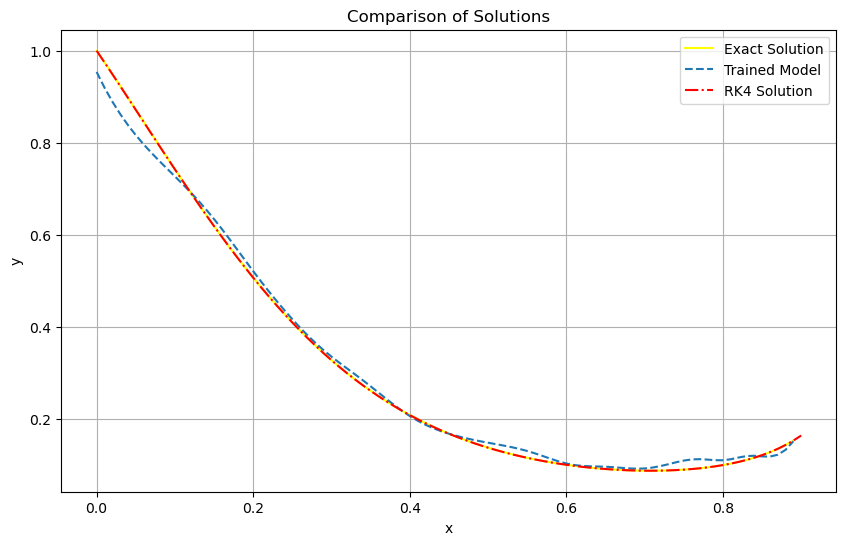

In [10]:
##rk4 solver

def rk4_solver(f, x0, y0, h, n):

    x = [x0]
    y = [y0]
    
    for i in range(n):
        k1 = h * f(x[-1], y[-1])
        k2 = h * f(x[-1] + 0.5 * h, y[-1] + 0.5 * k1)
        k3 = h * f(x[-1] + 0.5 * h, y[-1] + 0.5 * k2)
        k4 = h * f(x[-1] + h, y[-1] + k3)
        
        x.append(x[-1] + h)
        y.append(y[-1] + (k1 + 2*k2 + 2*k3 + k4) / 6)
    
    return np.array(x), np.array(y)

def loss_fn_rk(model, inputs, x_reg, reg_weight):
    # Equation loss
    model_output = model(inputs)
    deriv_model = calc_deriv(model_output, inputs)
    deriv_exact = dfdx_equation(inputs, model_output)
    ode_loss = criterion(deriv_model, deriv_exact)

    # Boundary loss, f(0) = 0
    boundary_model = model(torch.tensor([[0.0]]))
    boundary_exact = torch.tensor([[1.0]])
    boundary_loss = criterion(boundary_model, boundary_exact)
    
    # Regularization loss
    reg_model_output = model(x_reg)
    reg_loss = criterion(reg_model_output, f_exact(x_reg))

    # RK4 solution and loss
    x_rk4, y_rk4 = rk4_solver(dfdx_equation, 0.0, 1.0, 0.01, 90)  # Adjust step size and number of steps as needed
    y_rk4_tensor = torch.tensor(y_rk4, dtype=torch.float32).unsqueeze(1)
    rk4_loss = criterion(model(torch.tensor([[0.0]])), y_rk4_tensor)

    return ode_loss + boundary_loss + reg_weight * reg_loss + rk4_loss

# After training loop

# Plot RK4 results
x_rk4, y_rk4 = rk4_solver(dfdx_equation, 0.0, 1.0, 0.01, 90)  # Adjust step size and number of steps as needed

rk4_model_loss = criterion(torch.tensor(y_rk4).unsqueeze(1), f_exact(torch.tensor(x_rk4).unsqueeze(1)))

print(f"RK4: Loss: {rk4_model_loss.item():.6f}")

plt.figure(figsize=(10, 6))

# Plot exact solution
x_exact = torch.arange(0.0, 0.9, 0.01).unsqueeze(1)
y_exact = f_exact(x_exact).detach().numpy().flatten()
plt.plot(x_exact, y_exact, label='Exact Solution', color='yellow')

# Plot trained model solution
y_model = model(x_exact).detach().numpy().flatten()
plt.plot(x_exact, y_model, label='Trained Model', linestyle='--')

# Plot RK4 solution
plt.plot(x_rk4, y_rk4, label='RK4 Solution', linestyle='-.', color='red')

plt.title('Comparison of Solutions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


In [55]:
import torch
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from qadence import *
from qadence.types import BasisSet, ReuploadScaling

def dfdx_equation(x: torch.Tensor, f: torch.Tensor) -> torch.Tensor:
    return (5*(4*x**3 + x**2 - 2*x - 0.5))*f

def f_exact(x: torch.Tensor) -> torch.Tensor:
    return torch.exp(5*(x**4 + (1/3)*x**3 - x**2 - 0.5*x))

def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs=torch.ones_like(inputs),
        create_graph=True,
        retain_graph=True,
    )[0]
    return grad

criterion = torch.nn.MSELoss()

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor, x_reg: torch.Tensor, reg_weight: float) -> torch.Tensor:
    model_output = model(inputs)
    deriv_model = calc_deriv(model_output, inputs)
    deriv_exact = dfdx_equation(inputs, model_output)
    ode_loss = criterion(deriv_model, deriv_exact)

    boundary_model = model(torch.tensor([[0.0]]))
    boundary_exact = torch.tensor([[1.0]])
    boundary_loss = criterion(boundary_model, boundary_exact)

    reg_model_output = model(x_reg)
    reg_loss = criterion(reg_model_output, f_exact(x_reg))

    return ode_loss + boundary_loss + reg_weight * reg_loss

def regularization_weight(nj, niter, ndrop, delta_j):
    return 1 - np.tanh((nj - ndrop) / (delta_j * niter))

def model_(n_qubits, depth, layers):
    fm1 = feature_map(
        n_qubits=n_qubits,
        param="x",
        fm_type=BasisSet.CHEBYSHEV,
        reupload_scaling=ReuploadScaling.TOWER,
    )
    fm = chain()
    for i in range(layers):
        fm = chain(fm, fm1)

    ansatz = hea(n_qubits=n_qubits, depth=depth)

    observable = ising_hamiltonian(n_qubits=n_qubits)

    circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
    Model = QNN(circuit=circuit, observable=observable, inputs=["x"])

    return Model

def main(n_qubits, n_epochs, n_points, depth, layers, learning_rate):
    xmin = 0.0
    xmax = 0.9
    min_loss = float('inf')
    best_model_state = None

    model = model_(n_qubits, depth, layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    max_grad_norm = 1.0  # Gradient clipping value

    x_reg = torch.linspace(xmin, xmax, steps=20).unsqueeze(1)

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        x_train = (xmin + (xmax - xmin) * torch.rand(n_points, requires_grad=True)).unsqueeze(1)

        reg_weight = regularization_weight(epoch, n_epochs, ndrop=100, delta_j=0.1)

        loss = loss_fn(model, x_train, x_reg, reg_weight)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

        optimizer.step()

        if loss.item() < min_loss:
            min_loss = loss.item()
            best_model_state = model.state_dict()

        if loss.item() <= 0.001:
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Best model loss:", min_loss)

    return model, min_loss

# Define ranges for your hyperparameters
n_epochs = 250
n_points = 20
n_qubits = 6
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
layers = [1, 2, 3, 4, 5, 6, 7, 8]
depths = [3, 6, 9, 12, 15]

# Container for results
results = []

# Generate all combinations of hyperparameters
for lr, d, l in itertools.product(learning_rates, depths, layers):
    model, loss = main(n_qubits, n_epochs, n_points, depth=d, layers=l, learning_rate=lr)
    results.append((lr, d, l, loss))

# Convert results to numpy array for easier handling
results = np.array(results)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    results[:, 0], results[:, 1], results[:, 2],
    c=results[:, 3], cmap='viridis'
)

# Label axes
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Depth')
ax.set_zlabel('Layers')

# Add color bar which maps values to colors
cbar = plt.colorbar(sc)
cbar.set_label('Loss')

plt.show()


Best model loss: 19.032168571947494


KeyboardInterrupt: 